## First!  Let's make sure we can undersample!

https://github.com/glemaitre/UnbalancedDataset

** Let's install UnbalancedDataset: **

```
git clone https://github.com/fmfn/UnbalancedDataset.git
cd UnbalancedDataset
python setup.py install
```

####Then restart kernel


Data is from: https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

From UCI:

###Data Set Information:


We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.


###Attribute Information:

The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses. 


Specifically: 
- X1	Relative Compactness 
- X2	Surface Area 
- X3	Wall Area 
- X4	Roof Area 
- X5	Overall Height 
- X6	Orientation 
- X7	Glazing Area 
- X8	Glazing Area Distribution 
- y1	Heating Load 
- y2	Cooling Load


Heating load is heat energy to be put into a heating system via heating apparatus.


Cooling load is the amount of heat energy to be removed from a building by the HVAC equipment to maintain the house at indoor design temperature when worst case outdoor design temperature is being experienced.



NOTE: For this lab - we will mostly be looking at this as a classification problem - identifying building features that lead to "high" heating loads.

In [5]:
import pandas as pd, numpy as np

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split 
from sklearn.neighbors import KNeighborsClassifier

from unbalanced_dataset import UnderSampler, OverSampler, SMOTE
# import unblanaced_dataset

from bokeh.plotting import figure,show,output_notebook
from bokeh.models import Range1d
output_notebook()

#import seaborn as sns

%matplotlib inline

ImportError: No module named unbalanced_dataset

In [6]:
sns.set_style("darkgrid")

NameError: name 'sns' is not defined

In [8]:
en = pd.read_csv('../data/ENB2012_data.csv',header=0)
en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 10 columns):
rel_compact          768 non-null float64
surface              768 non-null float64
wall                 768 non-null float64
roof                 768 non-null float64
height               768 non-null float64
orientation          768 non-null int64
glazing_area         768 non-null float64
glazing_area_dist    768 non-null int64
heating_load         768 non-null float64
cooling_load         768 non-null float64
dtypes: float64(8), int64(2)
memory usage: 66.0 KB


In [10]:
en[['heating_load','cooling_load']]

,heating_load,cooling_load
0,16,21
1,16,21
2,16,21
3,16,21
4,21,28
5,21,25
6,21,25
7,20,30
8,20,27
9,20,22


In [12]:
en[['heating_load','cooling_load']].describe().T #transpose

,count,mean,std,min,25%,50%,75%,max
heating_load,768,22.290365,10.113325,6,13,19,32,43
cooling_load,768,24.579427,9.520797,11,16,22,33,48


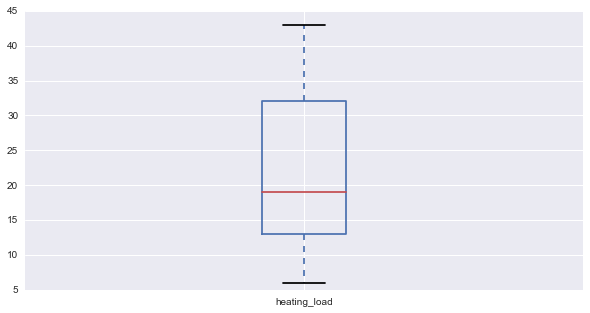

In [76]:
en.heating_load.plot(kind='box', figsize=(10,5))

## Exercize !

Say we wanted to predict whether or not a building has a high heating load (>= 40). We would then create a new feature where heating_load is greater than or equal to 40:

*_You can create new feautres by referencing a new key in your dataframe for this exercize._


In [13]:
en.head(5)

,rel_compact,surface,wall,roof,height,orientation,glazing_area,glazing_area_dist,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7,2,0,0,16,21
1,0.98,514.5,294.0,110.25,7,3,0,0,16,21
2,0.98,514.5,294.0,110.25,7,4,0,0,16,21
3,0.98,514.5,294.0,110.25,7,5,0,0,16,21
4,0.90,563.5,318.5,122.50,7,2,0,0,21,28


In [50]:
## This is important to reference later so we can use it as a threshold
# Solution here:

en['high_heat'] = en['heating_load'] >= 40

In [51]:
en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 11 columns):
rel_compact          768 non-null float64
surface              768 non-null float64
wall                 768 non-null float64
roof                 768 non-null float64
height               768 non-null float64
orientation          768 non-null int64
glazing_area         768 non-null float64
glazing_area_dist    768 non-null int64
heating_load         768 non-null float64
cooling_load         768 non-null float64
high_heat            768 non-null bool
dtypes: bool(1), float64(8), int64(2)
memory usage: 66.8 KB


How does our data set look now in terms of this target label:

In [52]:
print "Mean value: {:.03f}".format(en['high_heat'].mean())
print "\nValue Counts: "

en.high_heat.value_counts()

Mean value: 0.060

Value Counts: 


False    722
True      46
Name: high_heat, dtype: int64

In [53]:
en['high_heat'].mean()

0.059895833333333336

Let's classify! We'll use K nearest neighbors to see how well we do :D

## Exercize !

Build a KNN model with 5 neighbors, then check out the cross validation score.

In [54]:
# Use this data
data = en.iloc[:,:-2]
labels = en['high_heat']

cv_range = range(2,11)
empty_list = []

knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(data, labels)

for i in cv_range:
    the_score = cross_val_score(knn,data,labels,cv=i).mean()
    empty_list.append(the_score)
    
empty_list

knn.fit(data,labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [55]:
model_knn = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(model_knn, data, labels, cv = 5)
print "Crossvalidated KNN Model, Simple Accuracy: {:03f}".format(np.mean(scores))

# cross_val_score?

Crossvalidated KNN Model, Simple Accuracy: 0.977896


Hooray! 97% is great right? Well, the leading question might be giving the game away here: 97% is a good overall score but if our goal is to properly predict a High Heating Load building, then we'll need a bit more info. In classification, a confusion matrix is a way of showing finer detail of our classifier performance.

To get a confusion matrix, we need to look at only a single train/test split. So lets do that: 

In [56]:
data = en.iloc[:,:-2]
labels = en['high_heat']

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=1)  

# Build the classifier and get the predictions
model_knn = KNeighborsClassifier(5)

model_knn.fit(X_train, Y_train)  
predictions = model_knn.predict(X_test)

### Confusion Matrix
The confusion matrix shows the predicted values along the columns and the actual values along the rows. 


Sklearn defaults to alphabetical order so the Columns would read `False, True` as would our rows. These yield our **False Positives** (here we have 1 data point where we said the data point was `True` and it was `False`) and our **False Negatives** (6 predicted `False` but actually `True`). Our **True Positives** = 9.
Illustrated more cleanly:

In [57]:
cm = confusion_matrix(Y_test,predictions)
print cm

[[141   4]
 [  0   9]]


In [48]:
#lets make that easier to read
cm_df = pd.DataFrame(cm, index=['Predicted Class 0', 'Predicted Class 1'], 
                     columns=['Actual Class 0', 'Actual Class 1'])

cm_df

,Actual Class 0,Actual Class 1
Predicted Class 0,68,2
Predicted Class 1,0,84


## Exercize !

To get a sense about how different settings and models perform.

In [ ]:
# How does our matrix change if we change the heating_load threshold to 20?


In [ ]:
# How does our matrix change if we change the number of neighbors?



In [70]:
# How does our matrix score change if we use a different classifier like logistic regression?

# Build the classifier and get the predictions

# Fit

# Predict

# Confusion matrix

# Optional:  Make our Matrix easier to read


How are these results? Are they good?  What could be the problem?  Let's make our evaluation easier to look at.

#ROC (Receiver Operator Characteristic) Plots
The ROC curve illustrates the performance of a binary classifier system as its discrimination threshold is varied. We use ROC to compare models using the Area Under Curve (AUC) statistic. Generally, 1 is a perfect model and < 0.5 is worse than guessing. Remember for logistic regression, our probability function looks like:

In [58]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    
    p = figure(title='Receiver Operating Characteristic')
    # Plot ROC curve
    p.line(x=fpr,y=tpr,legend='ROC curve (area = %0.3f)' % roc_auc)
    p.x_range=Range1d(0,1)
    p.y_range=Range1d(0,1)
    p.xaxis.axis_label='False Positive Rate or (1 - Specifity)'
    p.yaxis.axis_label='True Positive Rate or (Sensitivity)'
    p.legend.orientation = "bottom_right"
    show(p)
    
%matplotlib inline

In [59]:
# Let's reset our data
en = pd.read_csv('../data/ENB2012_data.csv',header=0)

# Set a target
en['high_heat'] = en.heating_load >= 40

# Set are labels for training
label = en['high_heat']

# remove extranious features
data = en.drop(['heating_load','cooling_load','high_heat'], axis=1)

# Split our data into train and test splits
train_feat, test_feat, train_target, test_target = train_test_split(data, label, train_size=0.3)

In [60]:
model_lr = LogisticRegression(C=1).fit(train_feat, train_target)
target_predicted_proba = model_lr.predict_proba(test_feat)

In [62]:

plot_roc_curve(test_target, target_predicted_proba)

NameError: global name 'figure' is not defined

In [63]:
neg = en[en['high_heat'] == False]
pos = en[en['high_heat'] == True]

oversample_en = pd.concat([neg, pos.sample(700, replace = True)])
label = oversample_en['high_heat']
data = oversample_en.drop(['heating_load','cooling_load','high_heat'],axis=1)
train_feat, test_feat, train_target, test_target = train_test_split(data,label, train_size=0.3)

In [64]:
model_lr = LogisticRegression(C=.1).fit(train_feat, train_target)
target_predicted_proba = model_lr.predict_proba(test_feat)

plot_roc_curve(test_target, target_predicted_proba)

NameError: global name 'figure' is not defined

## Unbalanced Classes Setup

See above for external package setup..

Back to our confusion matrix.  Let's refresh our data first.

In [ ]:
en = pd.read_csv('../data/ENB2012_data.csv',header=0)
en.info()

Remember our results?  Could be better right?

###Strategy 1: Sample from the overloaded class
If we put the two classes on the same order of magnitude we can hope that our Model de-emphasizes its accuracy on the Falses with hopes of improving our scores on predicting the underrepresented class. One approach is to use less data from our overloaded class.

In [78]:
# 'Random under-sampling'

x = data.values
y = labels.values

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)  

In [ ]:
#Note we are keeping our test set out of this undersampling routing
US = UnderSampler(verbose=True)
usx, usy = US.fit_transform(X_train,Y_train)

In [ ]:
### Lets plug this undersampled data back into a dataframe to see how it looks now. 
us_df = pd.DataFrame(usx, columns=data.columns)
us_df['labels'] = usy
us_df.describe().T

###Exercise

- Using our new UnderSampled Data, test the performance of Logistic Regression, Naive Bayes, and KNN on this data. 

In [80]:
# Logistic Regression




In [81]:
#KNN 





In [82]:
#Navie Bayes:





Did this get better?  What happened?

Well, yes and no. We traded off between precision, correctly classifying as over 40, and recall, classifying more of the positives as positives. In practice, a mixture of both Over & Under sampling is used. 

###Strategy 2: Oversample the underrepresented class

To oversample, we will use all of our negative values and sample from our positive values a number that's more reasonable. Note the `replace = True` argument: we need to sample **with replacement** meaning after we sample a value, we replace the value we sampled in our original set, so it remains un changed. Before, sampling was done without replacement, guarnteeing unique values.

Sampling with replacement is not the same as SMOTE, which creates synthetic data. For more information on SMOTE, check out the original paper here: https://www.jair.org/media/953/live-953-2037-jair.pdf

In [ ]:
# 'Random over-sampling'

x = data.values
y = labels.values


X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)  

In [ ]:
verbose = True
ratio = 10.0

OS = SMOTE(ratio=ratio, verbose=verbose)
osx, osy = OS.fit_transform(X_train, Y_train)

In [ ]:
os_df = pd.DataFrame(osx, columns=data.columns)
os_df['labels'] = osy
os_df.describe().T

###Exercise

- Using our new OverSampled Data, test the performance of Logistic Regression, Naive Bayes, and KNN on this data.  

In [ ]:
#Logistic Regression:




In [ ]:
#KNN Model





In [ ]:
#Naive Bayes Model





But the model got worse or better? (worse)
Well, yes and no. We traded off between precision, correctly classifying as over 40, and recall, classifying more of the positives as positives. In practice, a mixture of both Over & Under sampling is used. 

###Exercise
- Repeat our process for a high cooling load
- Reinstantiate your data and then set the high cooling load at an appropriate value (I'll get you started).

In [3]:
en = pd.read_csv('../data/ENB2012_data.csv',header=0)
en['high_cool'] = en.cooling_load >= 40
en.high_cool.value_counts()

False    721
True      47
Name: high_cool, dtype: int64

In [ ]:
#Fit a logistic regression without using over or undersampling:




In [ ]:
#Fit a Logistic Regression using Undersampling:





In [ ]:
#Fit a Logistic Regression using Oversampling:



